https://medium.com/mlearning-ai/a-stochastic-model-for-demand-forecating-in-python-a1b568b80b94
  
https://mlpills.dev/time-series/forecasting-in-time-series/

https://forecastegy.com/posts/multiple-time-series-forecasting-nbeats-python/

In [ ]:
!pip install sktime
!pip install neuralforecast
!pip install statsforecast

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn import preprocessing, svm
from statsmodels.tsa.stattools import adfuller
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import OptimizedTheta, SeasonalNaive, HoltWinters
import datetime

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST, TimesNet
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, rmse
from neuralforecast.utils import AirPassengersDF

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import re
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
plt.rcParams["figure.figsize"] = (9,6)

### Functions

In [ ]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):

    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)

    all_orders = list(product(all_p, all_q, all_P, all_Q))

    print(f'Fitting {len(all_orders)} unique models')

    results = []

    for order in tqdm_notebook(all_orders):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                enforce_stationarity = False, enforce_invertibility = False).fit(disp=False)
        except:
            continue

        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
def ljung_box_test(residuals, is_seasonal, period):

    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])

        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()

    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
#######################
### Model framework ###
#######################

def cap_floor(train_dset, test_dset, name, growth = 'linear'):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    ### Baseline model ###

    m = Prophet()
    m.add_country_holidays(country_name='US')
    m.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_hrs = Prophet(weekly_seasonality = False,
                    daily_seasonality = False,
                    yearly_seasonality = True,
                    seasonality_mode = 'multiplicative',
                    changepoint_prior_scale = 0.01,
                    seasonality_prior_scale = 0.01,
                    holidays=holidays,
                    growth = growth)

    #m_hrs.add_regressor('Is_month_end')
    m_hrs.add_regressor('Year')
    m_hrs.add_regressor('Month')
    #m_hrs.add_regressor('Day')
    #m_hrs.add_regressor('Week')
    #m_hrs.add_regressor('Dayofyear')
    #m_hrs.add_regressor('Dayofweek')
    #m_hrs.add_regressor('Is_month_start')
    #m_hrs.add_regressor('Is_quarter_end')
    m_hrs.add_regressor('Is_quarter_start')
    #m_hrs.add_regressor('Is_year_end')
    m_hrs.add_regressor('Is_year_start')
    m_hrs.add_country_holidays(country_name='US')
    m_hrs.fit(train_dset)

    df_all = pd.DataFrame()

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    prop_test = mod_diag(m, 'Baseline model', test_dset, y_train, y_test, name)
    prop_test['Model'] = 'Baseline'
    df_all = pd.concat([df_all,prop_test], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    prop_test = mod_diag(m_hrs, 'Holiday-Regressor-Seasonal model', test_dset, y_train, y_test, name)
    prop_test['Model'] = 'HRS'
    df_all = pd.concat([df_all,prop_test], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    ax = sns.lineplot(x = "ds", y = "yhat", hue = "Model", markers = True, data = df_all)
    ax = sns.lineplot(x = "ds", y = "y", markers = True, data = df_all)
    ax.set(xlabel='Date', ylabel='Values')
    plt.show();

    return df_all

In [ ]:
def train_dset(dset,date_var):
    nonvar_lst = []
    time_data_ph = dset.drop([date_var + 'Elapsed'],axis = 1)
    time_data_ph[date_var] = time_data_ph[date_var].astype('datetime64[ns]')
    nonvar_lst = []
    for i in range(time_data_ph.shape[1]):
      if time_data_ph.iloc[:,i].nunique() == 1:
        nonvar_lst.append(time_data_ph.columns[i])

    time_data_ph = time_data_ph.drop(nonvar_lst,axis = 1)

    time_data_ph = time_data_ph.sort_values(date_var)
    time_data_ph['y'] = time_data_ph['y'].astype(int)
    time_data_ph.columns = time_data_ph.columns.str.lstrip(date_var)
    time_data_ph.rename(columns = {'':'ds'}, inplace = True)

    time_data_ph = time_data_ph.reset_index(drop=True)

    list2 = ['Is_month_end','Is_year_start','Is_month_end','Is_month_start','Is_month_end','Is_quarter_start','Is_year_end','Is_quarter_end']
    list1 = list(time_data_ph.columns)
    int_vars = [element for element in list1 if element in list2]

    for name in int_vars:
        time_data_ph[name] = time_data_ph[name].astype(int)
    return time_data_ph

In [ ]:
def mod_diag(model, mod_name, test_df, y_train, y_test, name):
    f = plt.figure(figsize=(19, 15))
    plot_series(y_train, y_test, labels=["y_train", "y_test"], title = f'{name} Train-test plot');

    forecast = cv_exam(model, test_df)
    print(list(forecast.columns))

    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    mape_ph = mean_absolute_percentage_error(forecast['y'], forecast['yhat'], symmetric=True)
    mse_ph = mean_squared_error(forecast['y'], forecast['yhat'], squared=False)
    print(f"The Smape loss value for {name} and {mod_name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} and {mod_name} model is {mse_ph:.6f}")

    plot_series(forecast['yhat'], forecast['y'], labels=["y_pred","y_test"], title = f'{name} {mod_name} Test predict-actuals plot')
    plt.show();

    fig = model.plot_components(forecast)

    ax = sns.lineplot(x="ds", y="residuals", markers=True, data=forecast)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();
    return forecast

def cv_exam(model, test_df):

    forecast = model.predict(test_df)
    forecast = pd.concat([forecast,test_df['y']], axis = 1)
    forecast['residuals'] = forecast.y - forecast.yhat

    return forecast

In [ ]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found "
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [ ]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method = "linear")
    ax = ts.plot(figsize = figsize, color = "red", alpha = 0.5,
                 title = "Remove outliers", label = "original", legend = True)
    ts_clean.plot(ax = ax, grid = True, color = "black",
                  label = "interpolated", legend = True)
    plt.show()
    return ts_clean

In [ ]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
    with plt.style.context(style='bmh'):

        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))

    ### plot ts with mean/std of a sample from the first x% ###
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'],
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index,
                           y1=dtf_ts['lower'].head(sample_size),
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')

    ### test stationarity (Augmented Dickey-Fuller) ###
    adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,autolag="AIC")
    adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
    p = round(p, 3)
    conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
    ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')

    ### pacf (for AR) eacf (for MA) ###
    smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
    smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,title="Autocorrelation (for MA component)")
    plt.tight_layout()

In [ ]:
def diag_res(model, mod_name):
  mape_ph = mean_absolute_percentage_error(crossvalidation_df['y'], crossvalidation_df[model], symmetric=True)
  mse_ph = mean_squared_error(crossvalidation_df['y'], crossvalidation_df[model], squared=False)
  print(f"The Smape loss value for {mod_name} using cross-validation is {mape_ph:.6f}")
  print(f"The RMSE loss value for {mod_name} using cross-validation is {mse_ph:.6f}")

In [ ]:
def all_mod(train_dset, test_dset, params, df_comp):

    auto_model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                         seasonality_prior_scale = params['seasonality_prior_scale'],
                         holidays_prior_scale = params['holidays_prior_scale'],
                         holidays = holidays)

    #auto_model.add_regressor('Is_month_end')
    auto_model.add_regressor('Year')
    auto_model.add_regressor('Month')
    #auto_model.add_regressor('Day')
    #auto_model.add_regressor('Week')
    #auto_model.add_regressor('Dayofweek')
    #auto_model.add_regressor('Dayofyear')
    #auto_model.add_regressor('Is_month_start')
    #auto_model.add_regressor('Is_quarter_end')
    auto_model.add_regressor('Is_quarter_start')
    auto_model.add_regressor('Is_year_start')

    ### Fit the model on the training dataset ###

    auto_model.fit(train_dset)

    ### Cross validation ###
    prop_test_auto = cv_exam(auto_model, test_dset)

    fig = auto_model.plot(prop_test_auto)
    a = add_changepoints_to_plot(fig.gca(), auto_model, prop_test_auto)

    mape_ph_auto = mean_absolute_percentage_error(prop_test_auto['y'], prop_test_auto['yhat'], symmetric=True)

    print(f"The Smape loss value for is {mape_ph_auto:.6f}")
    # 0.111345
    print(f"The RMSE value is {mean_squared_error(prop_test_auto['y'], prop_test_auto['yhat'], squared=False)}")
    # 1186.9104787999713
    plot_series(prop_test_auto['yhat'], test_ph['y'], labels=["y_pred", "y_test"], title = f'Prophet Hyperparameter Train-test plot')
    plt.show();

    ax = sns.lineplot(x="ds", y="residuals", markers=True, data=prop_test_auto)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();

    ### Model performance metrics ###
    #auto_model_pm = performance_metrics(prop_test_auto, rolling_window=1)
    #print(auto_model_pm)

    prop_test_auto['Model'] = 'Hyperparameter'

    df_comp = pd.concat([df_comp, prop_test_auto], axis = 0).reset_index(drop=True)

    ax = sns.lineplot(x="ds", y="yhat", hue="Model", markers=True, data=df_comp)
    ax = sns.lineplot(x="ds", y="y", markers=True, data=df_comp)
    ax.set(xlabel='Date', ylabel='Values')
    plt.show();
    return df_comp

### Read in the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Time Series")
# Print out the current directory
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Time Series


In [ ]:
df = pd.read_csv('data/AirPassengers.csv', index_col = 'Month', parse_dates = ['Month'])
df = df.reset_index()
df.rename(columns = {'Month' : 'Date'}, inplace = True)
print(df.shape)
df.head()

(144, 2)


Date  Passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121

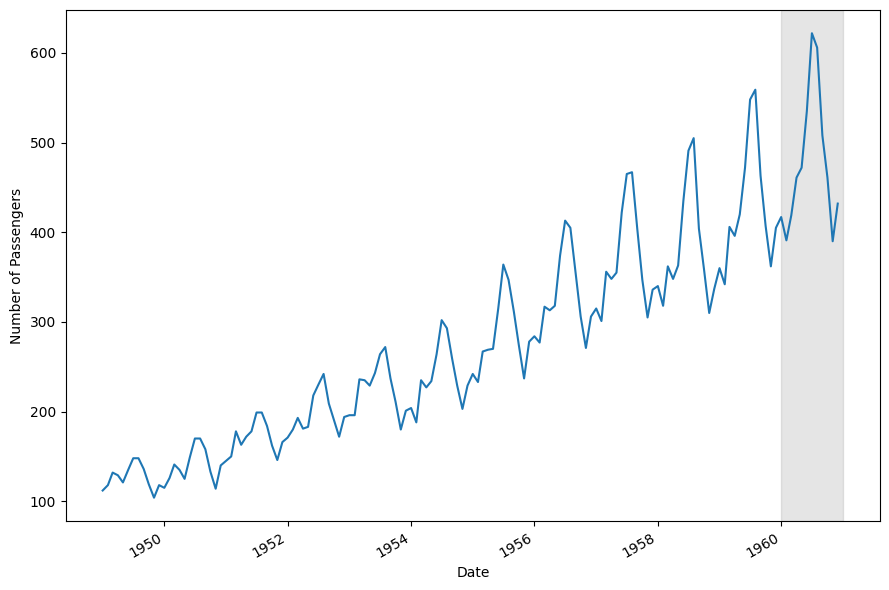

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')
ax.axvspan(*pd.to_datetime(["1960-01-01", "1961-01-01"]), color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

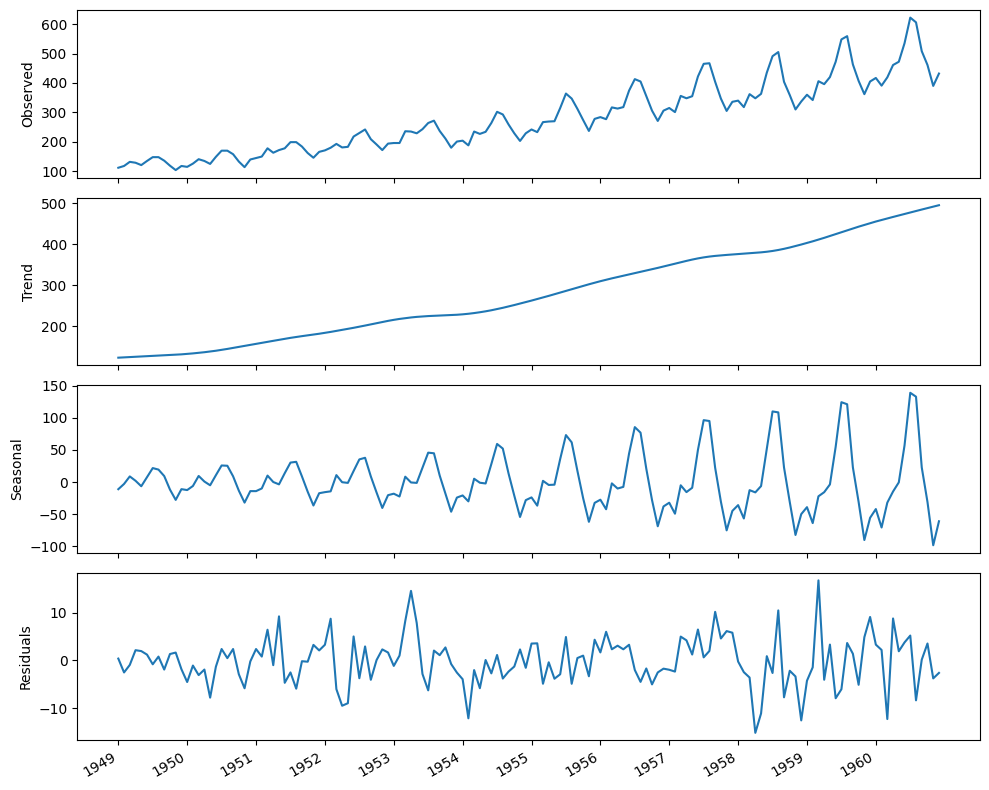

In [ ]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols = 1, sharex = True, figsize = (10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 143, 12), np.arange(1949, 1961, 1))

fig.autofmt_xdate()
plt.tight_layout()

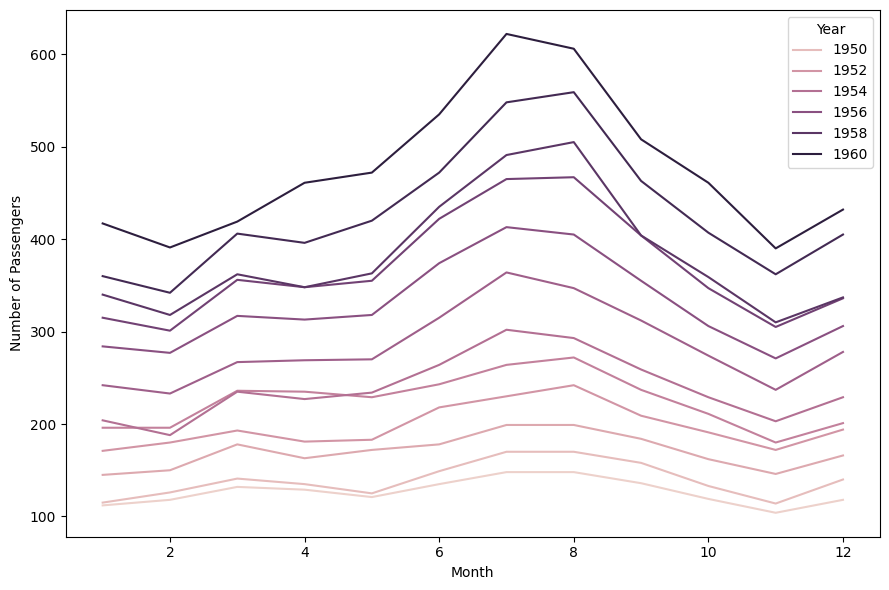

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
month_data = df.groupby(['Year','Month'])['Passengers'].mean().reset_index()


ax = sns.lineplot(x = "Month", y = "Passengers", hue = "Year", markers = True, data = month_data)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Passengers')

fig.autofmt_xdate()
plt.tight_layout()

### Outlier check

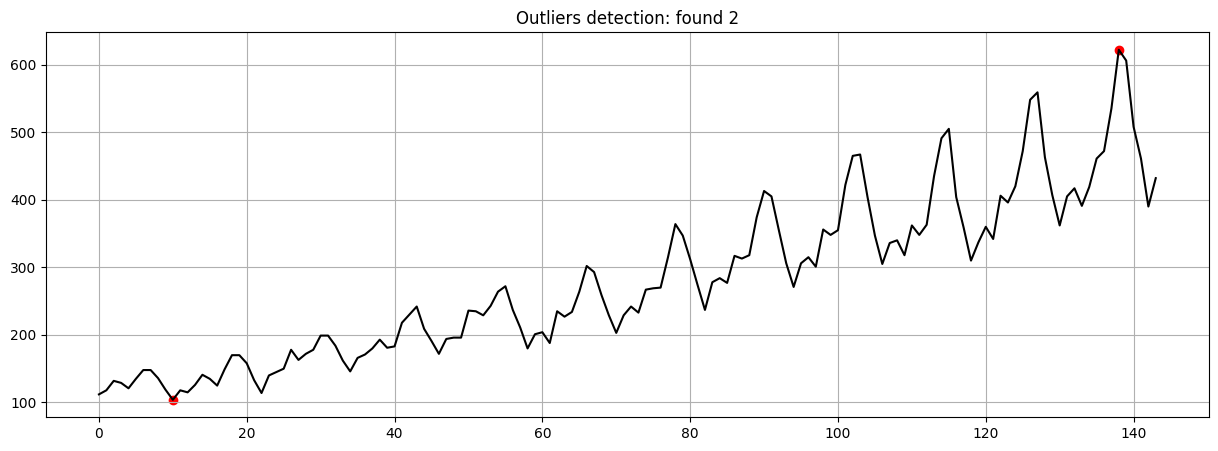

In [ ]:
dtf_outliers = find_outliers(df['Passengers'], perc=0.01)

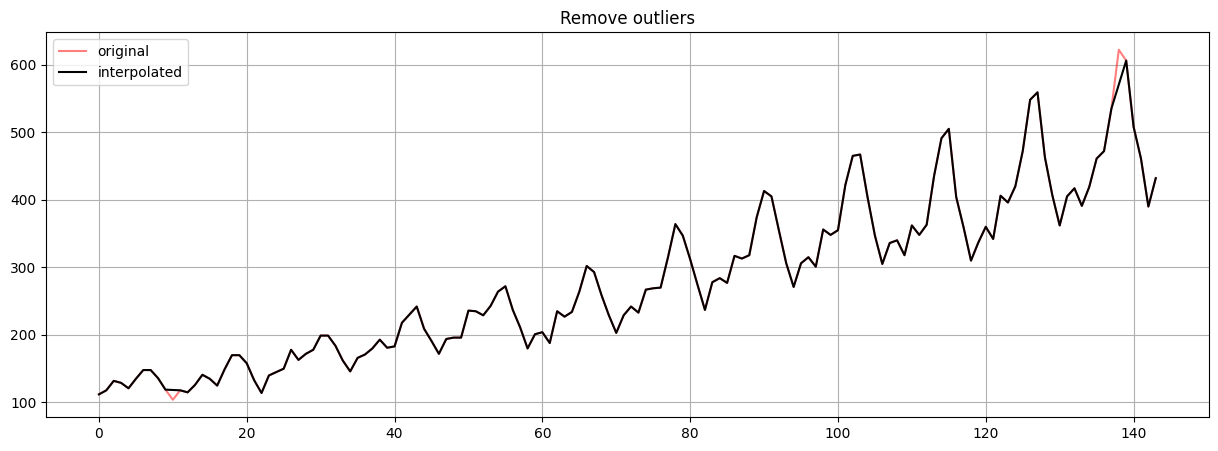

In [ ]:
### outliers index position ###
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"] == 1].index

### exclude outliers ###
ts_clean = remove_outliers(df['Passengers'], outliers_idx = outliers_index_pos)

In [ ]:
df_clean = pd.concat([df['Date'], ts_clean], axis = 1)
df = df_clean.copy()

### Test of stationarity

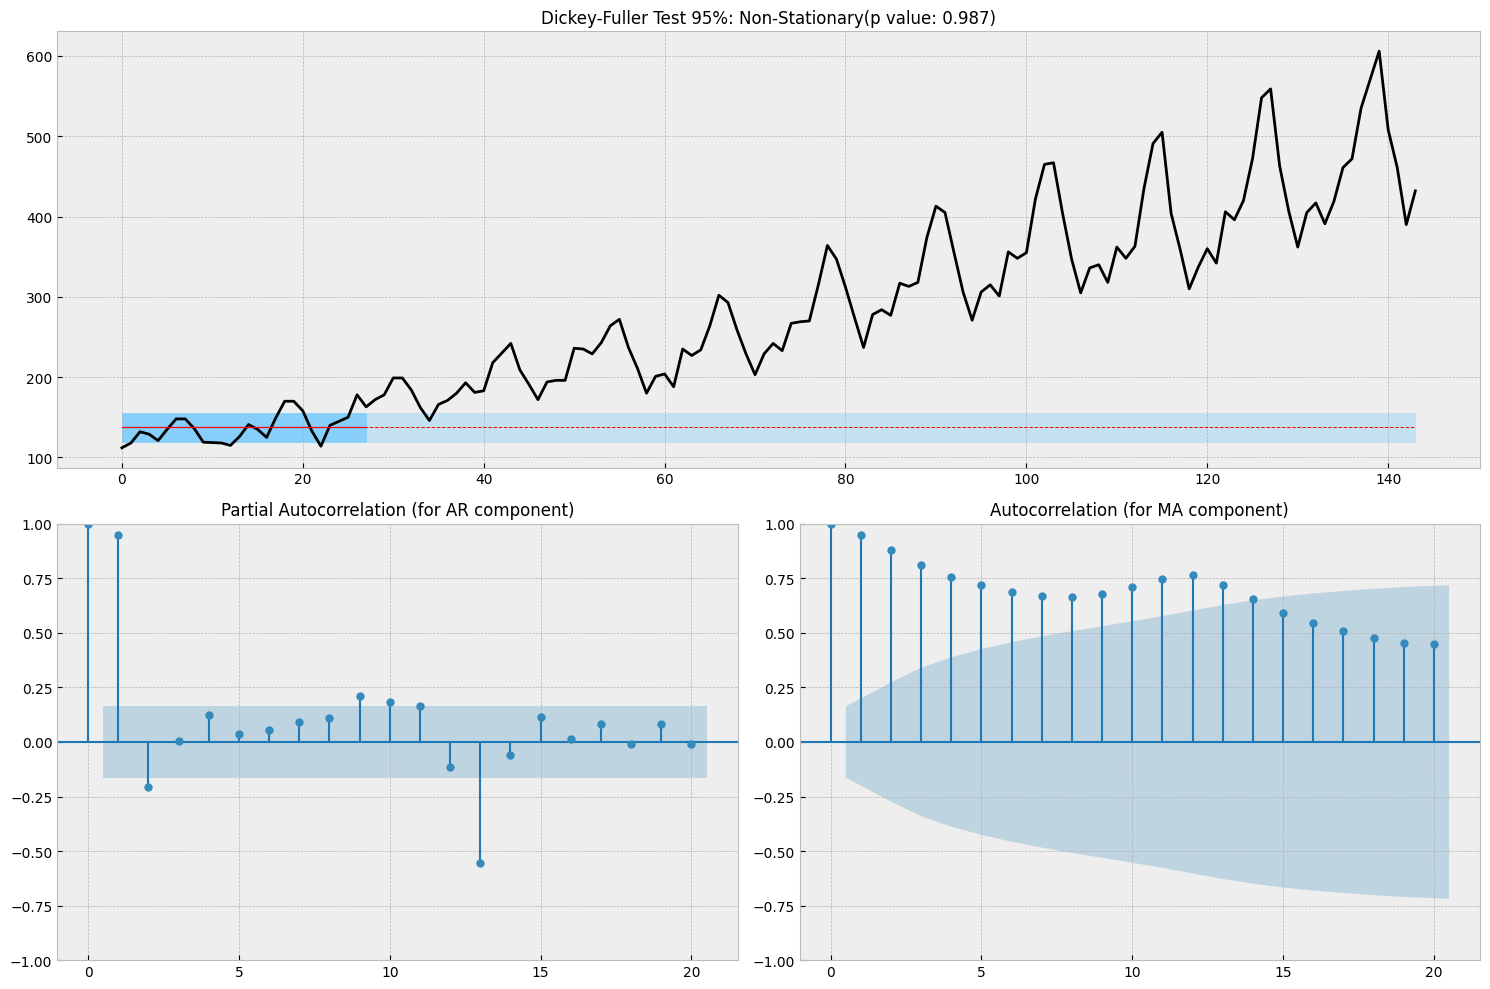

In [ ]:
test_stationarity_acf_pacf(df['Passengers'], sample = 0.20, maxlag = 20)

In [ ]:
df_diff = np.diff(df['Passengers'], n = 1)
df_seasonal_diff = np.diff(df_diff, n = 12)

ad_fuller_result = adfuller(df_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.535754514032622
p-value: 2.191267093850715e-28


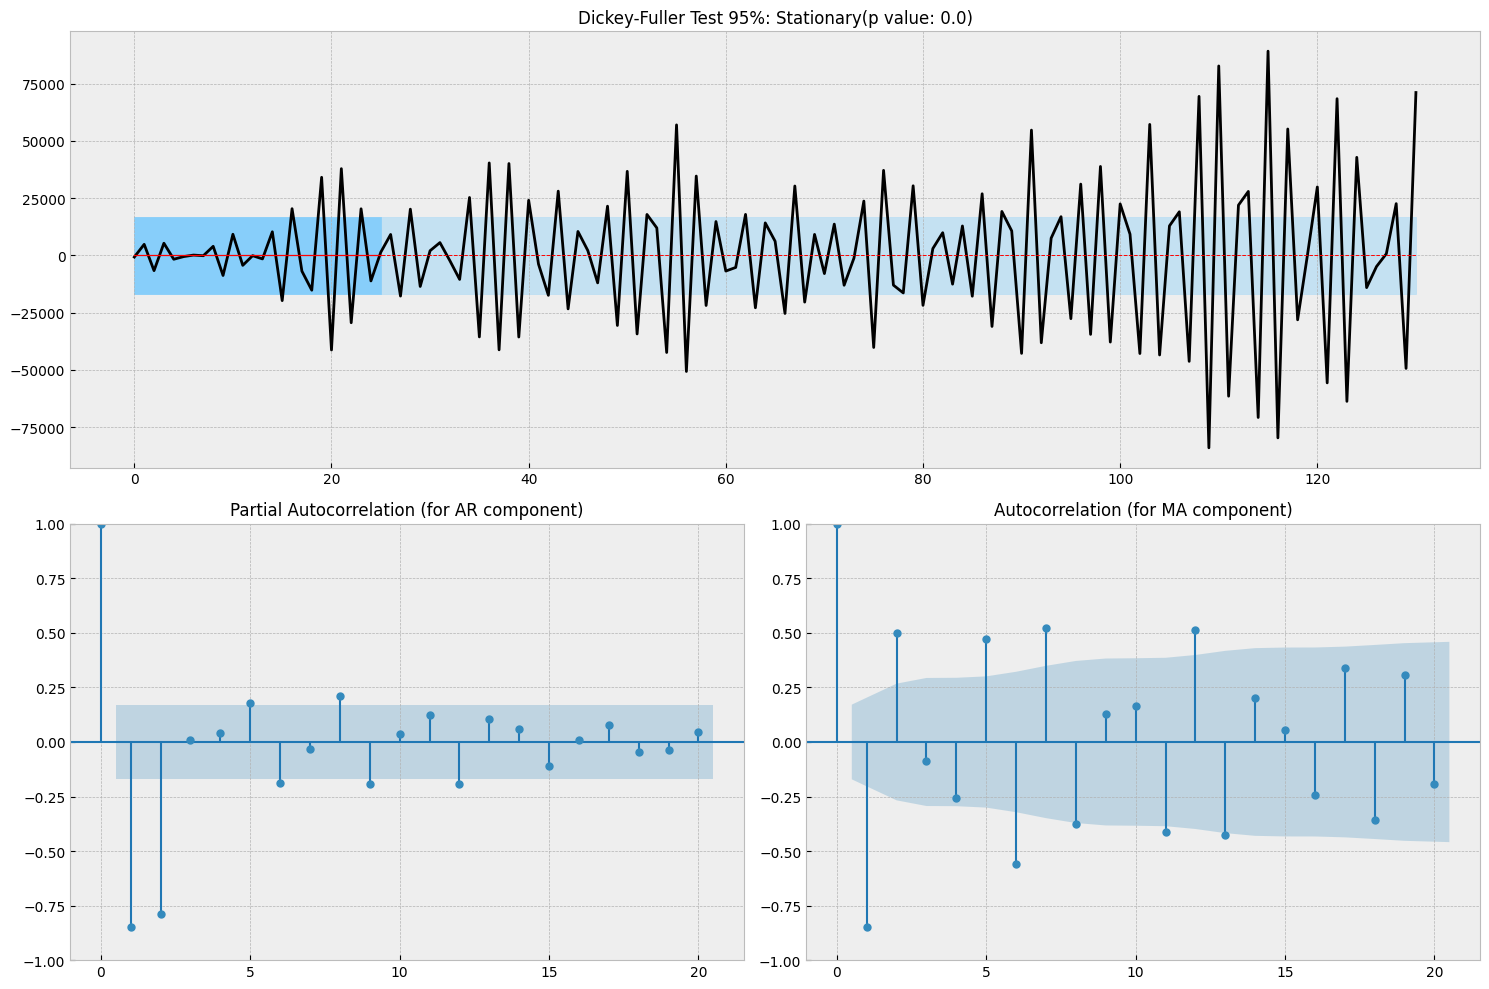

In [ ]:
test_stationarity_acf_pacf(pd.Series(df_seasonal_diff), sample = 0.20, maxlag = 20)

In [ ]:
df['unique_id'] = 0
df = df.rename(columns={"Date": "ds", "Passengers": "y"})
df = df[['unique_id', 'ds', 'y']]

train = df[:-24]
test = df[-24:]

### StatsForecast models

In [ ]:
season_length = 12
horizon = len(test)

sf = StatsForecast(
    df = train,
    models = [OptimizedTheta(season_length = season_length,
                             decomposition_type = "multipicative"),
              SeasonalNaive(season_length = season_length),
              HoltWinters(season_length = season_length, error_type = 'M')],
    freq = 'M',
    n_jobs = -1
)

In [ ]:
crossvalidation_df = sf.cross_validation(df = train,
                                         h = horizon,
                                         step_size = 1,
                                         n_windows = 3)

In [ ]:
print(min(crossvalidation_df.ds), max(crossvalidation_df.ds))

diag_res('OptimizedTheta', 'Optimized Theta')
diag_res('SeasonalNaive', 'Seasonal Naive')
diag_res('HoltWinters', 'Holt Winters')

1956-10-31 00:00:00 1958-11-30 00:00:00
The Smape loss value for Optimized Theta using cross-validation is 0.120396
The RMSE loss value for Optimized Theta using cross-validation is 58.091465
The Smape loss value for Seasonal Naive using cross-validation is 0.134311
The RMSE loss value for Seasonal Naive using cross-validation is 50.328091
The Smape loss value for Holt Winters using cross-validation is 0.049843
The RMSE loss value for Holt Winters using cross-validation is 22.928471


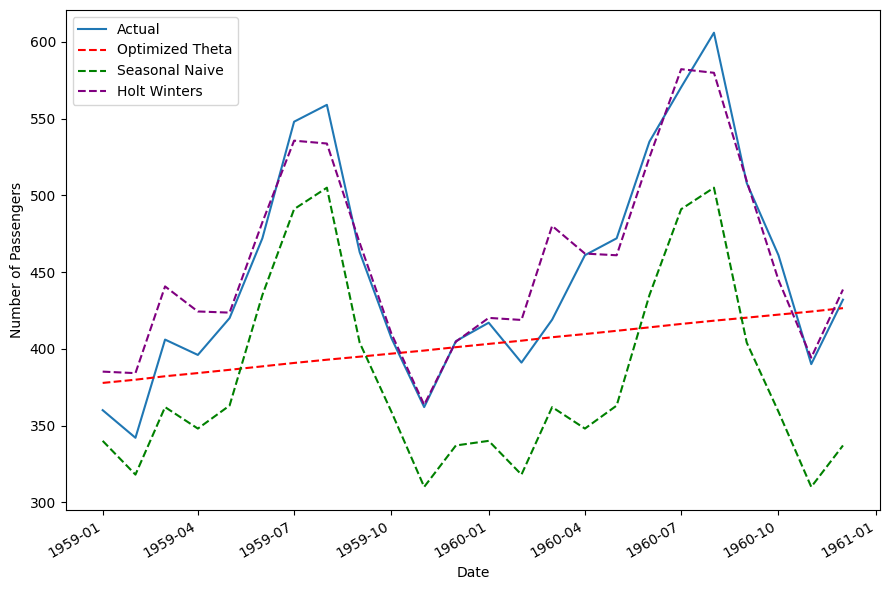

In [ ]:
Y_hat = sf.forecast(horizon, fitted = True)
test['unique_id'] = test['unique_id'].astype(int)
Y_hat.ds = pd.to_datetime(Y_hat.ds)
Y_hat.ds = Y_hat.ds + datetime.timedelta(days=1)
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(Y_hat1['ds'], Y_hat1['y'], label='Actual')
ax.plot(Y_hat1['ds'], Y_hat1['OptimizedTheta'], label = 'Optimized Theta', ls = '--', color = 'red')
ax.plot(Y_hat1['ds'], Y_hat1['SeasonalNaive'], label = 'Seasonal Naive', ls = '--', color = 'green')
ax.plot(Y_hat1['ds'], Y_hat1['HoltWinters'], label = 'Holt Winters', ls = '--', color = 'purple')

ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')

fig.autofmt_xdate()
plt.tight_layout()

### Neural models

In [ ]:
from ray import tune
from neuralforecast.auto import AutoNHITS, AutoNBEATS

val_size = 24
test_size = len(test)

horizon = 24

nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([2 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([10]),                                     # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10)
}

models = [NHITS(h = horizon,
                input_size = 2*horizon,
                max_steps = 50),
          AutoNHITS(h = horizon,
                    config = nhits_config),
          NBEATS(h = horizon,
                 input_size = 2*horizon,
                 max_steps = 50),
          PatchTST(h = horizon,
                   input_size = 2*horizon,
                   max_steps = 50),
          TimesNet(h = horizon,
                   input_size = 2*horizon,
                   max_steps = 50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(models = models, freq = 'M')

In [ ]:
preds_df = nf.cross_validation(df = df, val_size = val_size, test_size = test_size, n_windows = None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2023-11-23 10:17:37,010	INFO worker.py:1673 -- Started a local Ray instance.
2023-11-23 10:17:39,260	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-11-23 10:17:39,268	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2023-11-23_10-17-33   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2023-11-23_10-17-33
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2023-11-23_10-17-33`


(_train_tune pid=20281) Seed set to 3
(_train_tune pid=20281) 2023-11-23 10:17:46.075923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=20281) 2023-11-23 10:17:46.075993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=20281) 2023-11-23 10:17:46.076031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=20281) 2023-11-23 10:17:47.400504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 60.91it/s, v_num=0, train_loss_step=39.30, train_loss_epoch=39.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 67.33it/s, v_num=0, train_loss_step=26.70, train_loss_epoch=30.10, valid_loss=51.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 83.71it/s, v_num=0, train_loss_step=20.50, train_loss_epoch=24.00, valid_loss=59.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 69.46it/s, v_num=0, train_loss_step=17.60, train_loss_epoch=19.10, valid_loss=49.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 73.34it/s, v_num=0, train_loss_step=13.80, train_loss_epoch=13.50, valid_loss=50.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 80.02it/s, v_num=0, train_loss_step=11.30, train_loss_epoch=13.00, valid_loss=33.70]
Validatio

(_train_tune pid=20281) Seed set to 7


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 104.21it/s, v_num=0, train_loss_step=36.30, train_loss_epoch=38.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 102.58it/s, v_num=0, train_loss_step=24.00, train_loss_epoch=37.90, valid_loss=47.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20281) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 100.70it/s, v_num=0, train_loss_step=21.80, train_loss_epoch=20.90, valid_loss=37.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 102.41it/s, v_num=0, train_loss_step=15.70, train_loss_epoch=16.30, valid_loss=36.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 106.04it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=12.70, valid_loss=45.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 6

(_train_tune pid=20281) Seed set to 5


                                                                            
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 99.09it/s, v_num=0, train_loss_step=33.70, train_loss_epoch=36.10] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 98.27it/s, v_num=0, train_loss_step=24.80, train_loss_epoch=23.20, valid_loss=52.70] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 104.57it/s, v_num=0, train_loss_step=19.10, train_loss_epoch=17.60, valid_loss=39.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20281) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.40it/s]
(_train_tune pid=20281) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 80.70it/s, v_num=0, train_loss_step=12.90, train_loss_epoch=13.50, valid_loss=40.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 95.57

(_train_tune pid=20281) Seed set to 4


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 66.51it/s, v_num=0, train_loss_step=38.20, train_loss_epoch=41.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 68.05it/s, v_num=0, train_loss_step=32.80, train_loss_epoch=31.70, valid_loss=53.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 64.70it/s, v_num=0, train_loss_step=21.30, train_loss_epoch=20.10, valid_loss=37.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 70.89it/s, v_num=0, train_loss_step=17.20, train_loss_epoch=16.30, valid_loss=40.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 68.94it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=14.60, valid_loss=43.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20281) 
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 69.12i

(_train_tune pid=20281) Seed set to 1


(_train_tune pid=20281) 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 77.69it/s, v_num=0, train_loss_step=42.70, train_loss_epoch=40.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 70.99it/s, v_num=0, train_loss_step=32.40, train_loss_epoch=34.90, valid_loss=55.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 76.62it/s, v_num=0, train_loss_step=26.80, train_loss_epoch=25.40, valid_loss=49.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s, v_num=0, train_loss_step=19.70, train_loss_epoch=19.50, valid_loss=44.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 86.80it/s, v_num=0, train_loss_step=16.40, train_loss_epoch=18.00, valid_loss=38.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 74.19it/s, v_num=0, train_loss_step=13.60, train_loss_epoch=12.70, va

(_train_tune pid=20281) Seed set to 6


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.60it/s, v_num=0, train_loss_step=36.20, train_loss_epoch=37.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 102.82it/s, v_num=0, train_loss_step=24.30, train_loss_epoch=24.00, valid_loss=47.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20281) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.53it/s]
                                                                       
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 99.75it/s, v_num=0, train_loss_step=19.60, train_loss_epoch=18.60, valid_loss=44.40] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 98.58it/s, v_num=0, train_loss_step=17.10, train_loss_epoch=15.40, valid_loss=40.80] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 103.07it/s, v_num=0, train_loss_st

(_train_tune pid=20281) Seed set to 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 74.83it/s, v_num=0, train_loss_step=43.60, train_loss_epoch=40.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 71.96it/s, v_num=0, train_loss_step=38.50, train_loss_epoch=40.80, valid_loss=54.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s, v_num=0, train_loss_step=33.10, train_loss_epoch=32.50, valid_loss=50.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 65.23it/s, v_num=0, train_loss_step=23.00, train_loss_epoch=21.90, valid_loss=49.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 71.84it/s, v_num=0, train_loss_step=18.30, train_loss_epoch=18.80, valid_loss=42.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 66.93it/s, v_num=0, train_loss_step=16.10, train_loss_epoch=15.70, valid_loss=39.00]
Validatio

(_train_tune pid=20281) Seed set to 4


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 82.31it/s, v_num=0, train_loss_step=39.10, train_loss_epoch=42.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 77.35it/s, v_num=0, train_loss_step=34.30, train_loss_epoch=35.80, valid_loss=51.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20281) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 82.18it/s, v_num=0, train_loss_step=23.60, train_loss_epoch=27.90, valid_loss=50.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 83.90it/s, v_num=0, train_loss_step=18.90, train_loss_epoch=18.90, valid_loss=35.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s, v_num=0, train_loss_step=14.20, train_loss_epoch=15.10, valid_loss=38.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 83.96i

(_train_tune pid=20281) Seed set to 5


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 104.24it/s, v_num=0, train_loss_step=0.763, train_loss_epoch=0.801, valid_loss=18.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 84.94it/s, v_num=0, train_loss_step=39.90, train_loss_epoch=40.90]
(_train_tune pid=20281) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s, v_num=0, train_loss_step=29.40, train_loss_epoch=30.60, valid_loss=55.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 105.84it/s, v_num=0, train_loss_step=21.00, train_loss_epoch=21.00, valid_loss=51.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 103.60it/s, v_num=0, train_loss_step=17.80, train_loss_epoch=18.40, valid_loss=48.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 102.14it/s, v_num=0, train_loss_step=14.10, train_loss_epoch=15.

(_train_tune pid=20281) Seed set to 9


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 87.00it/s, v_num=0, train_loss_step=42.30, train_loss_epoch=41.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 93.99it/s, v_num=0, train_loss_step=35.90, train_loss_epoch=36.20, valid_loss=55.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 105.83it/s, v_num=0, train_loss_step=26.60, train_loss_epoch=29.70, valid_loss=53.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 100.04it/s, v_num=0, train_loss_step=20.90, train_loss_epoch=21.10, valid_loss=38.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s, v_num=0, train_loss_step=16.20, train_loss_epoch=16.10, valid_loss=39.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 104.54it/s, v_num=0, train_loss_step=12.10, train_loss_epoch=14.50, valid_loss=39.40]
Valid

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
#nf.models[0].results.get_best_result().config

In [ ]:
preds_df.ds = pd.to_datetime(preds_df.ds)
try:
  preds_df.drop(['y'], axis = 1, inplace = True)
except:
  preds_df = preds_df
preds_df.ds = preds_df.ds + datetime.timedelta(days = 1)
preds_df = pd.merge(preds_df, test, how='left', on=['unique_id', 'ds'])


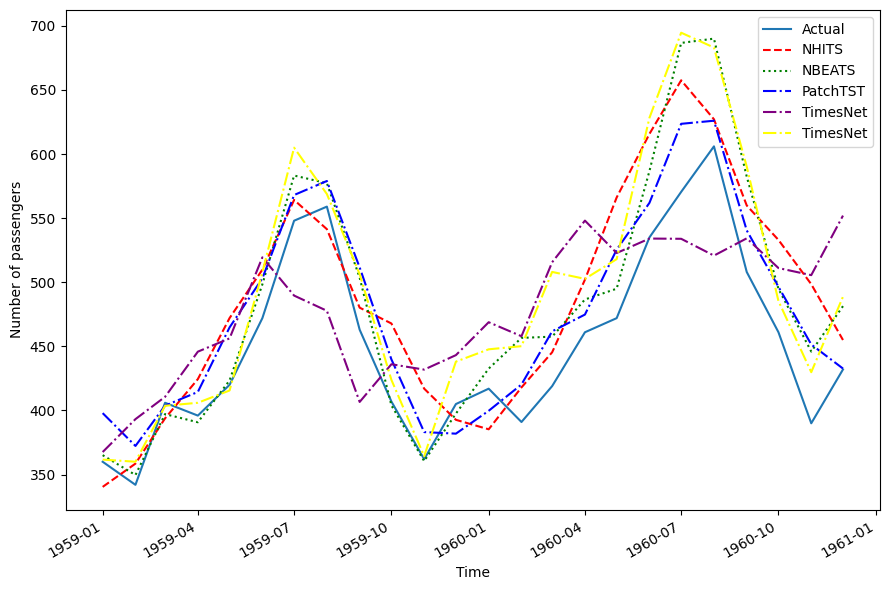

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(preds_df['ds'], preds_df['y'], label='Actual')
ax.plot(preds_df['ds'], preds_df['NHITS'], label='NHITS', ls='--', color = 'red')
ax.plot(preds_df['ds'], preds_df['NBEATS'], label='NBEATS', ls=':', color = 'green')
ax.plot(preds_df['ds'], preds_df['PatchTST'], label='PatchTST', ls='-.', color = 'blue')
ax.plot(preds_df['ds'], preds_df['TimesNet'], label='TimesNet', ls='-.', color = 'purple')
ax.plot(preds_df['ds'], preds_df['AutoNHITS'], label='TimesNet', ls='-.', color = 'yellow')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Number of passengers')

fig.autofmt_xdate()
plt.tight_layout()

### Prophet

In [ ]:
train = df[:-24]
test = df[-24:]

In [ ]:
add_datepart(train, 'ds', drop = False)
train_ph = train_dset(train,'ds')
train_ph.drop(['Dayofweek','Dayofyear','Week'], axis = 1, inplace = True)

add_datepart(test, 'ds', drop = False)
test_ph = train_dset(test,'ds')
test_ph.drop(['Dayofweek','Dayofyear','Week'], axis = 1, inplace = True)

#print(list(train_ph.columns))
#print(list(test_ph.columns))

test_ph.head()

ds    y  Year  Month  Is_quarter_start  Is_year_start
0 1959-01-01  360  1959      1                 1              1
1 1959-02-01  342  1959      2                 0              0
2 1959-03-01  406  1959      3                 0              0
3 1959-04-01  396  1959      4                 1              0
4 1959-05-01  420  1959      5                 0              0

In [ ]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
holidays = pd.DataFrame({
  'holiday':'federal',
  'ds': pd.to_datetime(['2018-07-04']),
  'lower_window': -2,
  'upper_window': 2,
})

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


120 24
['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'Armistice Day', 'Armistice Day_lower', 'Armistice Day_upper', 'Armistice Day (Observed)', 'Armistice Day (Observed)_lower', 'Armistice Day (Observed)_upper', 'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper', 'Christmas Day (Observed)', 'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper', 'Independence Day', 'Independence Day_lower', 'Independence Day_upper', 'Independence Day (Observed)', 'Independence Day (Observed)_lower', 'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower', 'Labor Day_upper', 'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper', "New Year's Day", "New Year's Day_lower", "New Year's Day_upper", "New Year's Day (Observed)", "New Year's Day (Observed)_lower", "New Year's Day (Observed)_upper", 'Thanksgiving', 'Thanksgiving_lower', 'Thanksgiving_upper', 'Veterans Day', 'Vete

<Figure size 1900x1500 with 0 Axes>

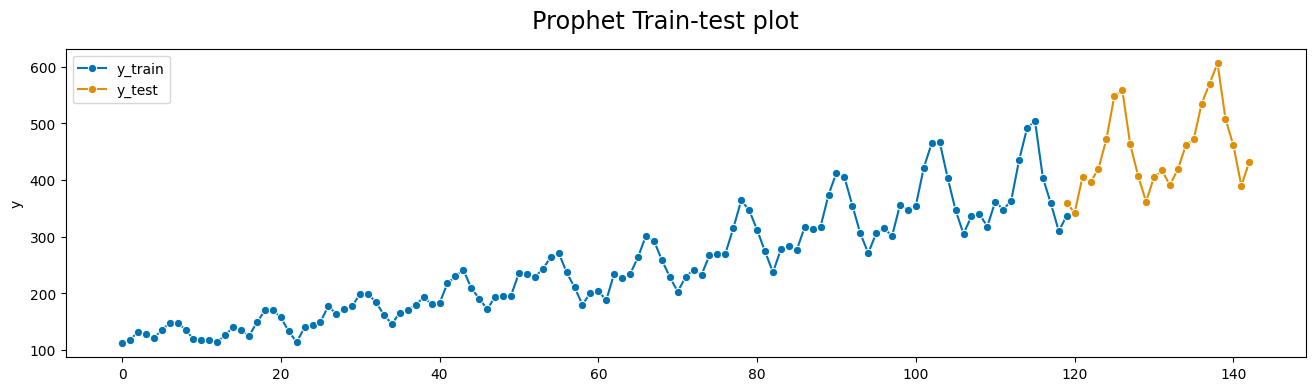

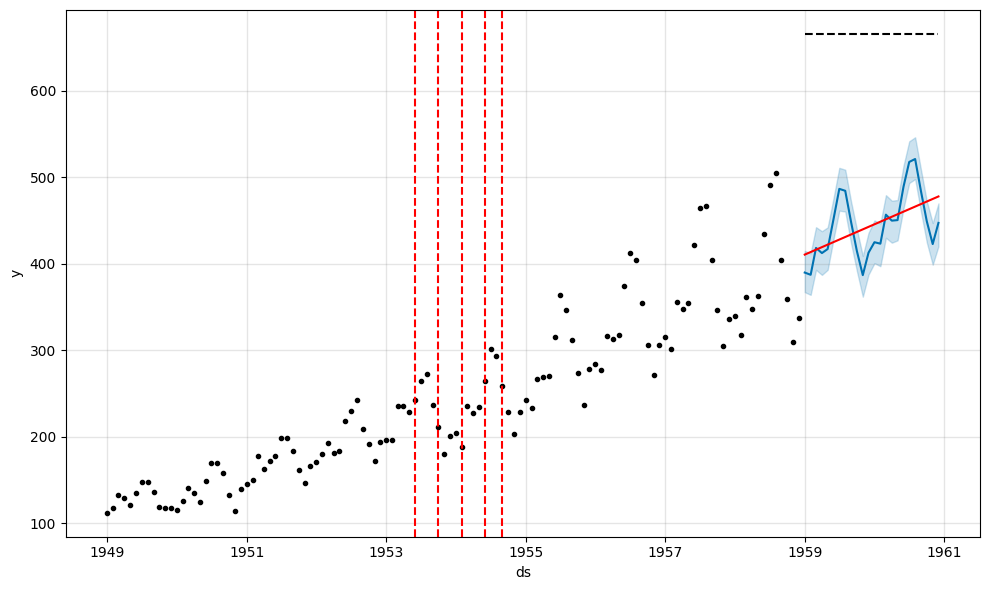

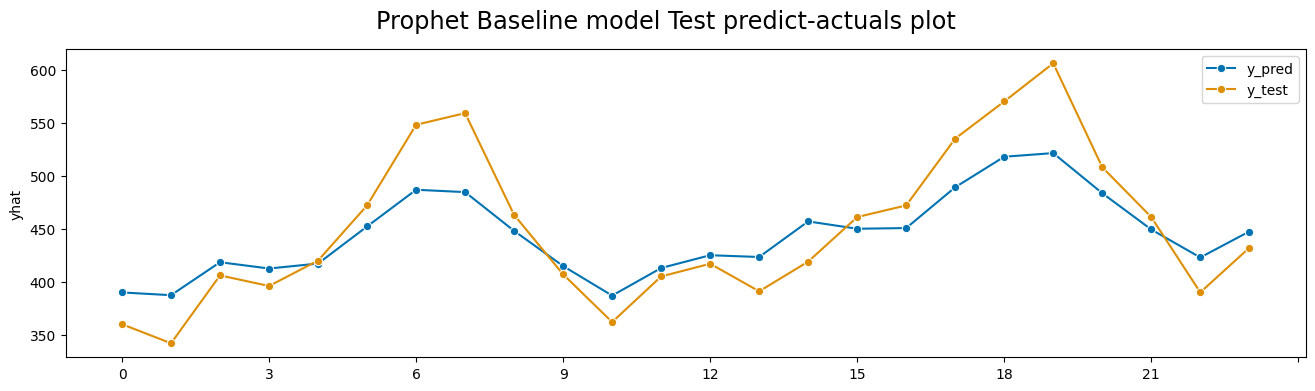

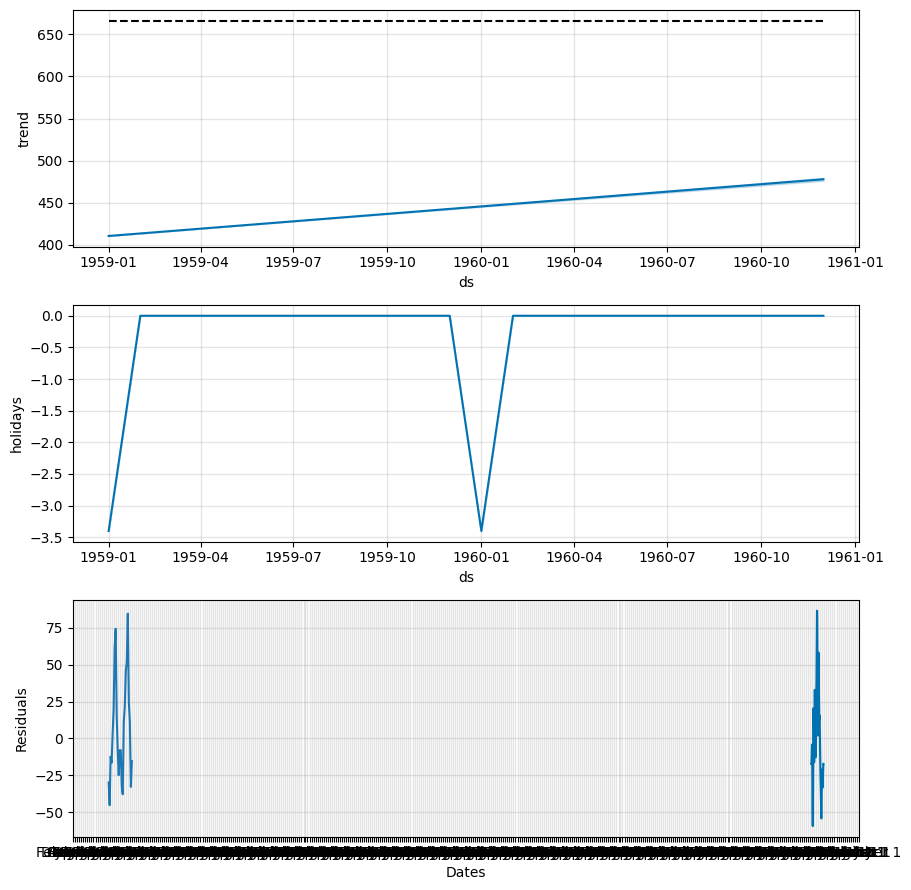

(24, 68)
['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'Armistice Day', 'Armistice Day_lower', 'Armistice Day_upper', 'Armistice Day (Observed)', 'Armistice Day (Observed)_lower', 'Armistice Day (Observed)_upper', 'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper', 'Christmas Day (Observed)', 'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper', 'Independence Day', 'Independence Day_lower', 'Independence Day_upper', 'Independence Day (Observed)', 'Independence Day (Observed)_lower', 'Independence Day (Observed)_upper', 'Is_quarter_start', 'Is_quarter_start_lower', 'Is_quarter_start_upper', 'Is_year_start', 'Is_year_start_lower', 'Is_year_start_upper', 'Labor Day', 'Labor Day_lower', 'Labor Day_upper', 'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper', 'Month', 'Month_lower', 'Month_upper', "New Year's Day", "New Year's Day_lower", "New Year's Day_upper", "New

<Figure size 1900x1500 with 0 Axes>

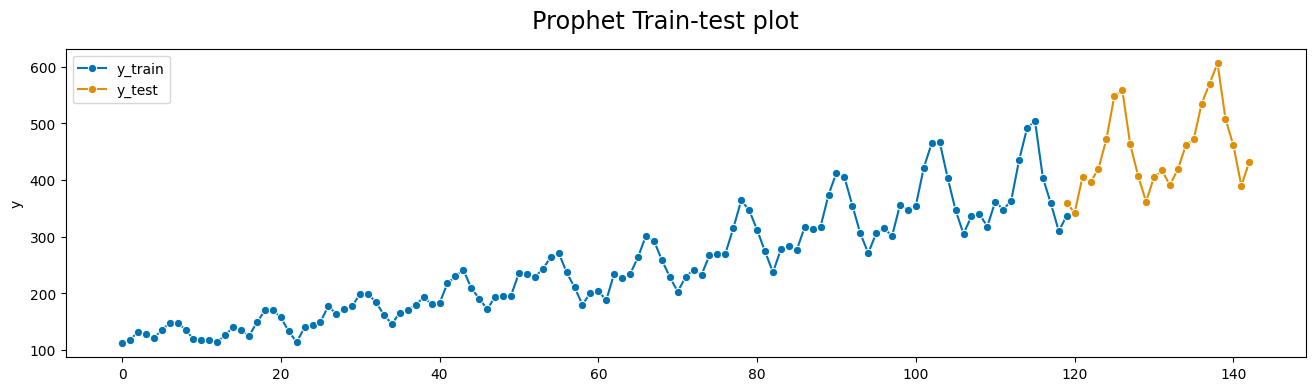

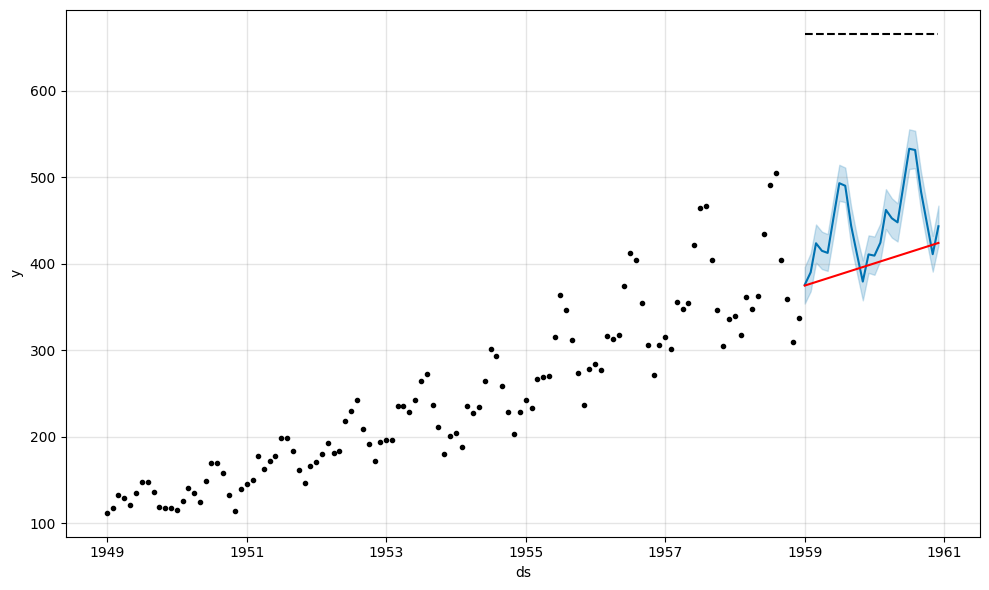

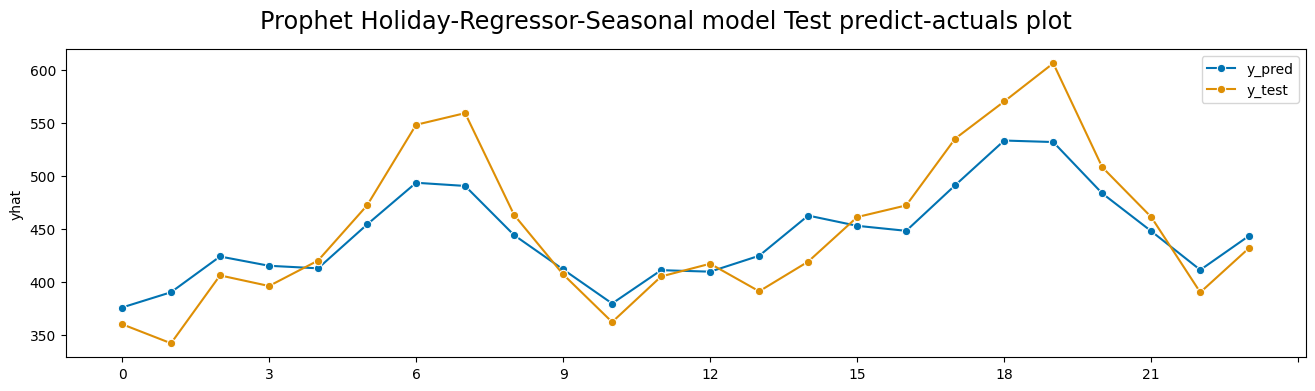

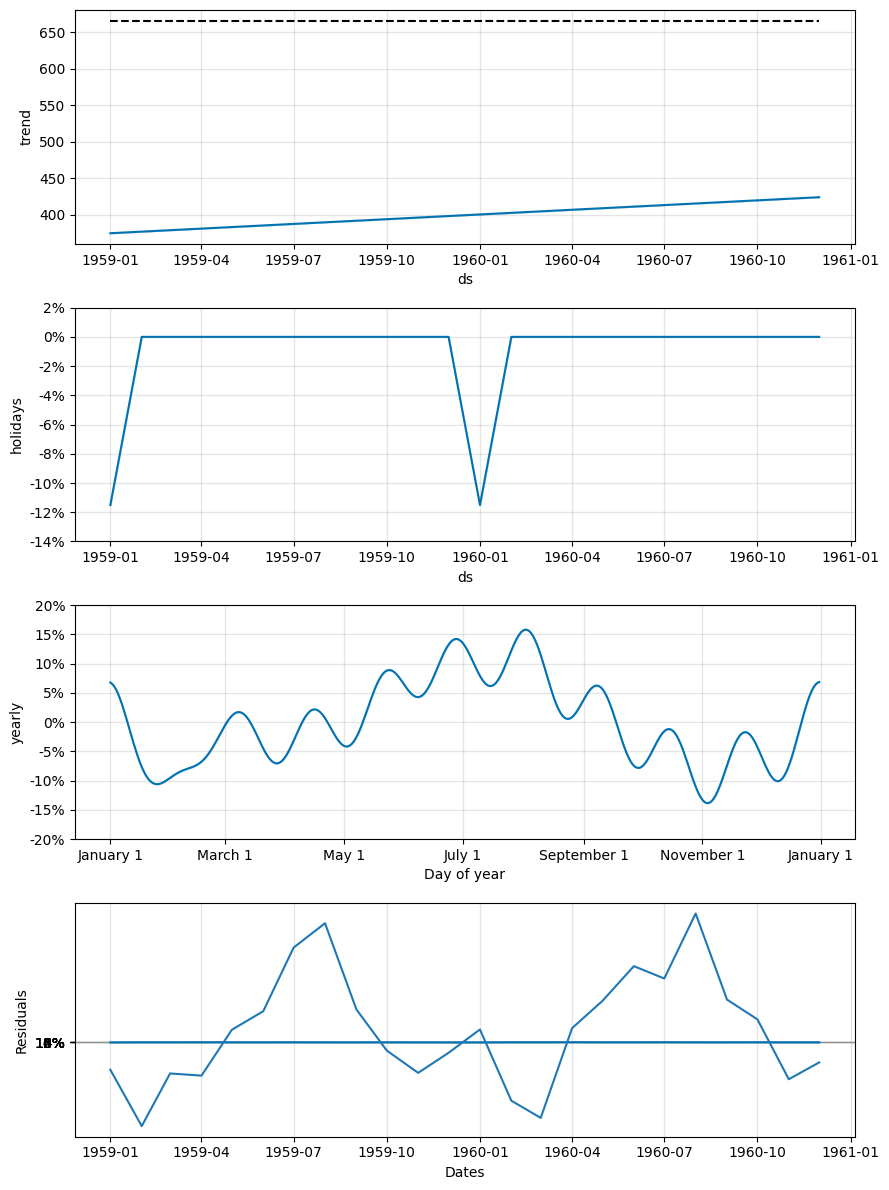

(48, 86)


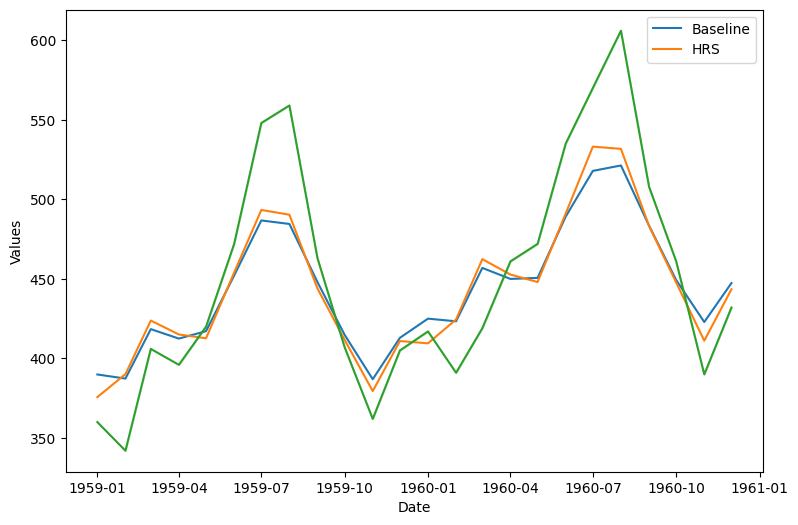

In [ ]:
cha_res = cap_floor(train_ph, test_ph, 'Prophet')

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

# for param in params:
#     m = Prophet(**param)
#     m.fit(train_ph)

#     df_cv = cross_validation(model = m, horizon = '24 M')
#     df_p = performance_metrics(df_cv, rolling_window = 1)
#     mses.append(df_p['mse'].values[0])

# tuning_results = pd.DataFrame(params)
# tuning_results['mse'] = mses

In [ ]:
#best_params = params[np.argmin(mses)]

best_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01}
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The Smape loss value for is 0.068363
The RMSE value is 43.08980998988324


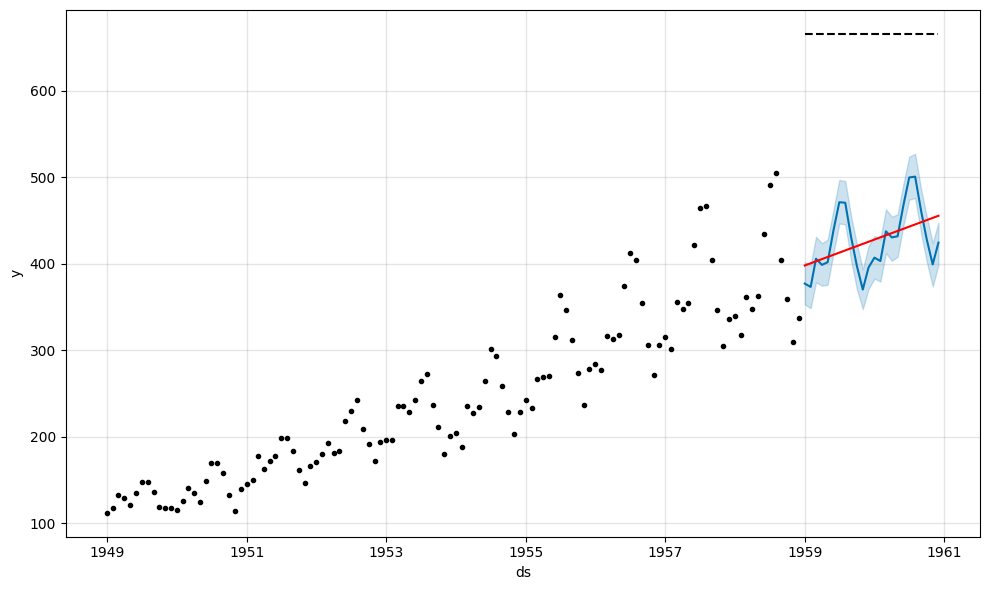

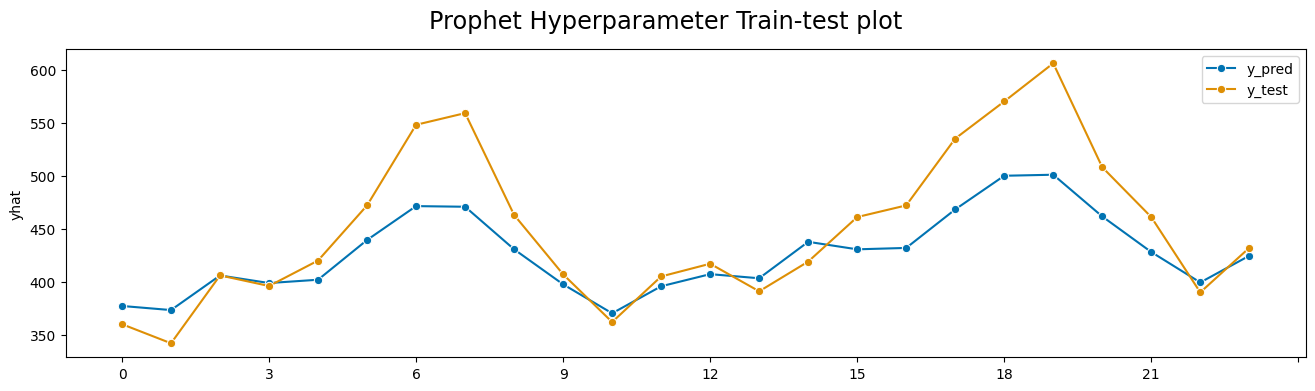

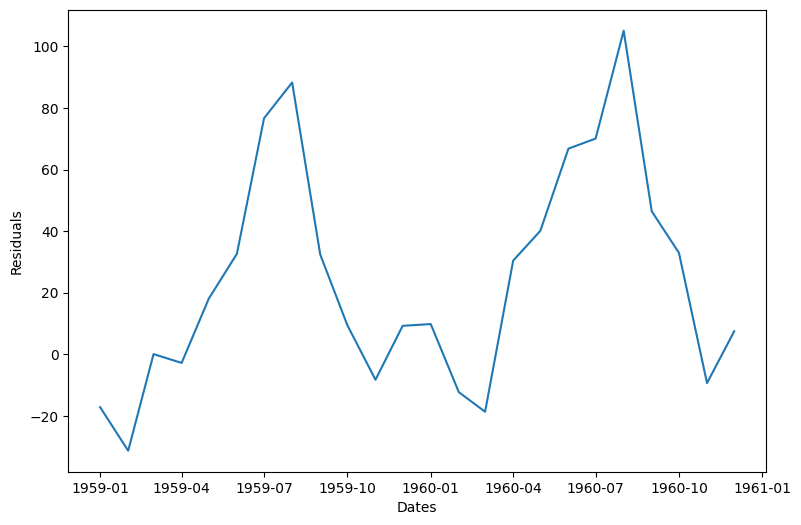

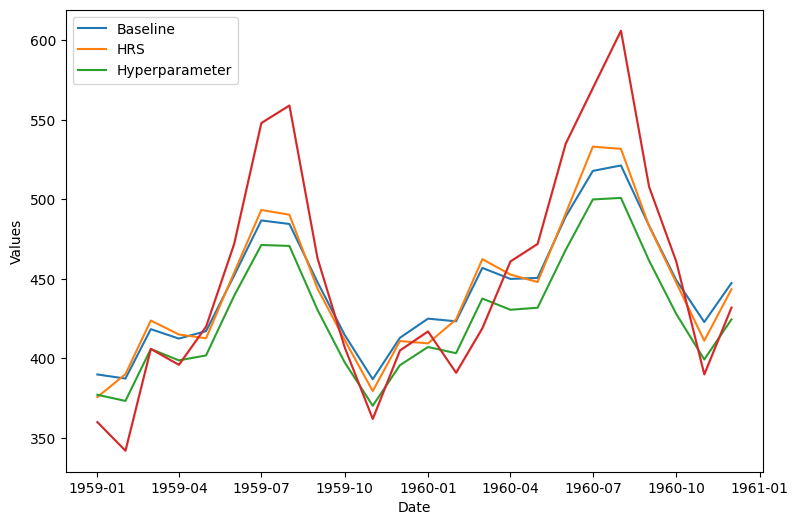

In [ ]:
auto_res = all_mod(train_ph, test_ph, best_params, cha_res)

### SARIMA

In [ ]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.009108382278024
p-value: 0.9943611289317581


In [ ]:
df_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.6321108329984497
p-value: 0.08654053918237781


In [ ]:
min_p = 0
max_p = 3
min_q = 0
max_q = 3

min_P = 0
max_P = 3
min_Q = 0
max_Q = 3

d = 1
D = 0
s = 12

result_df = SARIMA_gridsearch(train['y'], min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 256 unique models


  0%|          | 0/256 [00:00<?, ?it/s]

(p,q,P,Q)         AIC
0  (3, 2, 3, 2)  596.495120
1  (3, 2, 3, 0)  597.027972
2  (3, 0, 3, 1)  599.496898
3  (3, 3, 3, 1)  599.757015
4  (3, 1, 3, 0)  599.988687

In [ ]:
SARIMA_model = SARIMAX(np.asarray(train['y']), order=(3,1,2), seasonal_order = (3,0,2,12), enforce_stationarity = False, enforce_invertibility = False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(3, 0, 2, 12)   Log Likelihood                -287.248
Date:                            Thu, 23 Nov 2023   AIC                            596.495
Time:                                    12:04:56   BIC                            622.697
Sample:                                         0   HQIC                           607.000
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0515      0.149      0.345      0.730      -0.241       0.344
ar.L2         -0.5848      0.157   

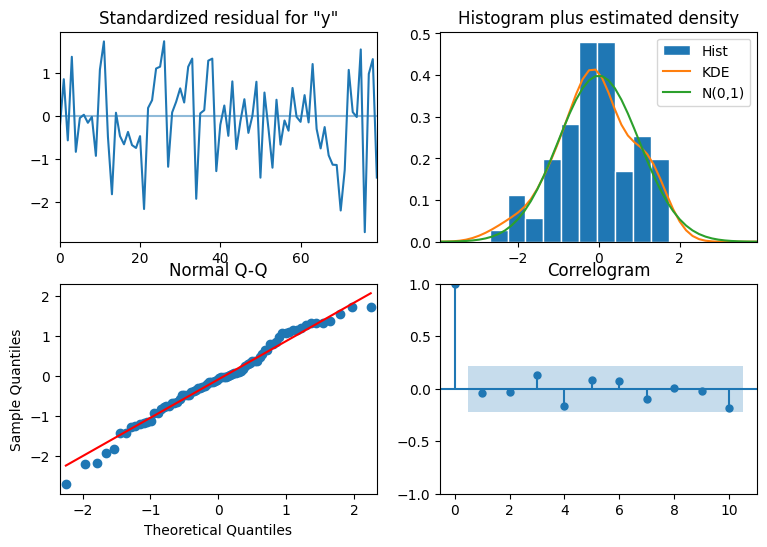

In [ ]:
SARIMA_model_fit.plot_diagnostics();

At least one p-value is smaller than 0.05


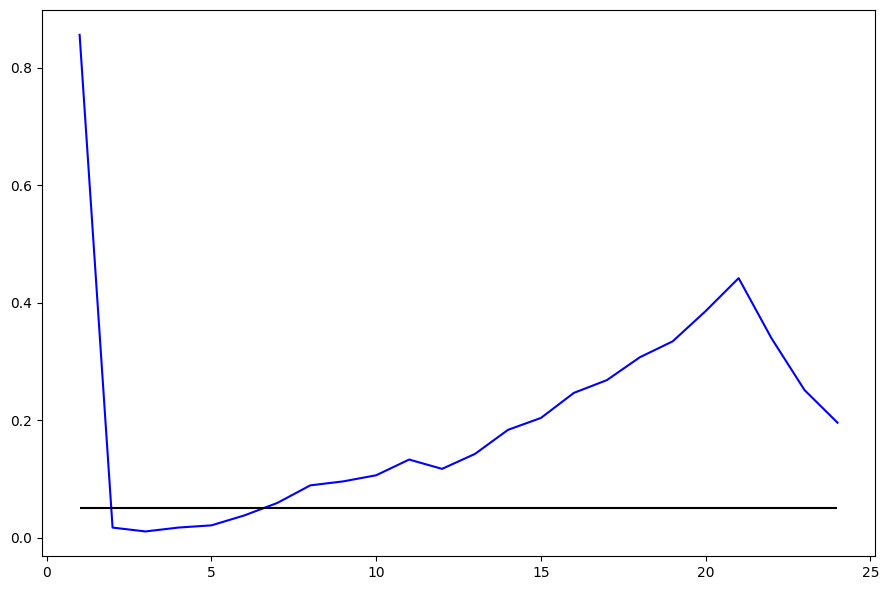

In [ ]:
residuals = SARIMA_model_fit.resid

ljung_box_test(residuals, True, 12)

In [ ]:
predictions = SARIMA_model_fit.get_prediction(1, len(test))
sarima_pred = test[['ds','y']].reset_index()
sarima_pred['yhat'] = pd.Series(predictions.predicted_mean)
sarima_pred['yhat'] = sarima_pred['yhat'] + 245
print(sarima_pred.shape)
sarima_pred.head()

(24, 4)


index         ds      y        yhat
0    120 1959-01-01  360.0  359.882468
1    121 1959-02-01  342.0  330.510312
2    122 1959-03-01  406.0  359.268908
3    123 1959-04-01  396.0  363.644411
4    124 1959-05-01  420.0  362.641685

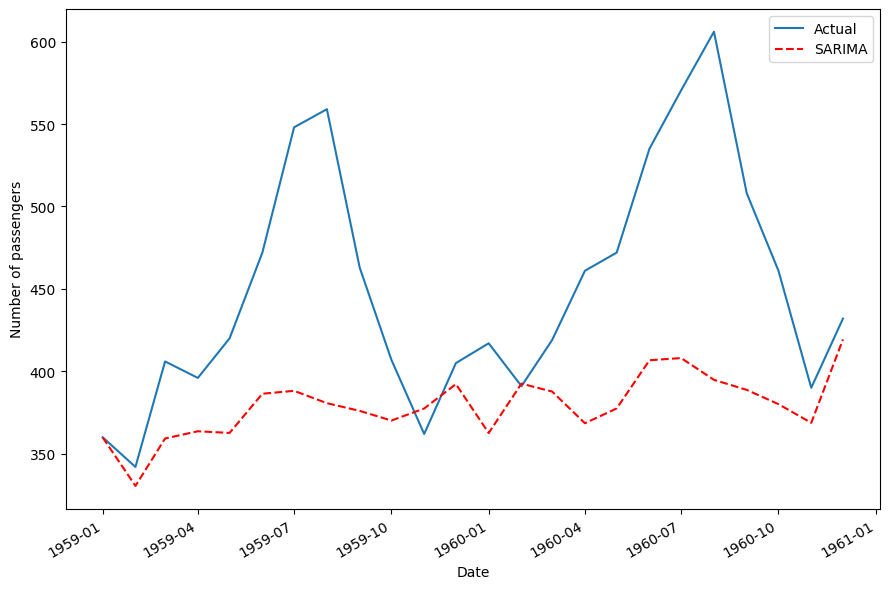

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(sarima_pred['ds'], sarima_pred['y'], label = 'Actual')
ax.plot(sarima_pred['ds'], sarima_pred['yhat'], label = 'SARIMA', ls = '--', color = 'red')

ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Number of passengers')

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation

In [ ]:
#preds_df.head()
print(list(set(cha_res.Model)))

['Baseline', 'HRS']


In [ ]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), rmse(preds_df['NHITS'], preds_df['y'])],
        'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), rmse(preds_df['NBEATS'], preds_df['y'])],
        'Auto N-HiTS': [mae(preds_df['AutoNHITS'], preds_df['y']), rmse(preds_df['AutoNHITS'], preds_df['y'])],
        'PatchTST': [mae(preds_df['PatchTST'], preds_df['y']), rmse(preds_df['PatchTST'], preds_df['y'])],
        'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), rmse(preds_df['TimesNet'], preds_df['y'])],
        'Baseline Prophet': [mae(cha_res.loc[cha_res.Model == 'Baseline', 'yhat'], cha_res.loc[cha_res.Model == 'Baseline', 'y']),
                             rmse(cha_res.loc[cha_res.Model == 'Baseline', 'yhat'], cha_res.loc[cha_res.Model == 'Baseline', 'y'])],
        'HRS Prophet': [mae(cha_res.loc[cha_res.Model == 'HRS', 'yhat'], cha_res.loc[cha_res.Model == 'HRS', 'y']),
                        rmse(cha_res.loc[cha_res.Model == 'HRS', 'yhat'], cha_res.loc[cha_res.Model == 'HRS', 'y'])],
        'Hyperparameter Prophet': [mae(auto_res.loc[auto_res.Model == 'Hyperparameter', 'yhat'], auto_res.loc[auto_res.Model == 'Hyperparameter', 'y']),
                                   rmse(auto_res.loc[auto_res.Model == 'Hyperparameter', 'yhat'], auto_res.loc[auto_res.Model == 'Hyperparameter', 'y'])],
        'Optimized Theta': [mae(Y_hat1['OptimizedTheta'], Y_hat1['y']), rmse(Y_hat1['OptimizedTheta'], Y_hat1['y'])],
        'Seasonal Naive': [mae(Y_hat1['SeasonalNaive'], Y_hat1['y']), rmse(Y_hat1['SeasonalNaive'], Y_hat1['y'])],
        'Holt Winters': [mae(Y_hat1['HoltWinters'], Y_hat1['y']), rmse(Y_hat1['HoltWinters'], Y_hat1['y'])],
        'SARIMA': [mae(sarima_pred['yhat'], sarima_pred['y']), rmse(sarima_pred['yhat'], sarima_pred['y'])]
        }

metrics_df = pd.DataFrame(data = data)
metrics_df.index = ['mae', 'rmse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)